In [457]:
import pandas as pd
import numpy as np
import word2vec
from collections import Counter, defaultdict
from scipy.sparse import csr_matrix

import keras.optimizers as optim

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [ ]:
import model

# Make Dataset

In [ ]:
selected_frames = pd.read_json('data/selected_frames.json')
selected_frames = selected_frames[selected_frames.law.str.len() == 1]
selected_frames.loc[selected_frames.pos_title == '', 'pos_title'] = float('nan')
selected_frames.columns = pd.MultiIndex.from_product([['raw'], selected_frames.columns])

In [ ]:
selected_frames['data', 'Arg1'] = selected_frames.raw.pos_title.map(lambda x: next(zip(*x)), na_action='ignore').fillna('')
selected_frames['data', 'Arg2'] = selected_frames.raw.pos_content.map(lambda x: next(zip(*x)), na_action='ignore')
selected_frames['data', 'Relation'] = selected_frames.raw.law.map(lambda x: x[0])

for id, row in selected_frames.data.iterrows():
    for col in ['Arg1', 'Arg2']:
        selected_frames.loc[id, ('data', col)] = [word for word in row[col] if word != row.Relation]

In [396]:
selected_frames.data.head()

,Arg1,Arg2,Relation
0,[],"[七, 年前, ，, 年, 僅, 九, 歲, 及, 八, 歲, 的, 板橋市, 某, 國小,...",殺人罪
1,"[0, ‧, 3, 坪, 喊價, 800萬, 畸零地, 圍籬, 阻, 路, 拆, ！]","[○, ．, 三, 坪, 畸零地, 能, 「, 螞蟻, 吃, 大象, 」, ？, 北市, 議...",道路交通管理處罰條例
2,"[100, cc, 催芽劑奪, 信義, 鄉四, 命]","[信義, 鄉民, 朱明福, ，, 涉嫌, 將, 催芽劑, 摻入, 米酒, ，, 導致, 前,...",殺人罪
3,"[101, 前董座, 林鴻明, 二審, 輕, 判, 1年, 8月]","[前, 台北, 101, 董事長, 林鴻明, ，, 被, 控, 掏空, 股票, 上市, 的,...",證券交易法
4,"[101, 大樓, 前添, 紛爭, 台獨, 大, 旗, 砸傷, 人]","[台北, 101, 大樓, 前, 法輪, 功, 、, 愛國, 同心, 會, 的, 爭端, ，...",傷害罪


In [313]:
selected_frames.data.Arg2.str.len().rename('Content Length').describe()

count    4022.000000
mean      364.184237
std       122.985570
min        40.000000
25%       296.000000
50%       366.000000
75%       444.000000
max       807.000000
Name: Content Length, dtype: float64

In [444]:
trainset, validset = train_test_split(selected_frames, test_size=0.25, random_state=42)

In [273]:
relation = dataset.data.Relation.unique()
print('# Train set'.ljust(20), '%5d'%len(trainset))
print('# Valid set'.ljust(20), '%5d'%len(validset))
print('# Law'.ljust(20), '%5d'%len(relation))

# Train set           3016
# Valid set           1006
# Law                  274


In [317]:
selected_frames.data.to_pickle('data/selected_frames.data.p')

## Word2Vec

In [ ]:
f_wordvec = 'data/wordvec.txt'

In [ ]:
corpus = trainset.data.Arg1.map(' '.join, na_action='ignore')
corpus.dropna().to_csv('data/corpus.txt', index=None)
corpus = trainset.data.Arg2.map(' '.join, na_action='ignore')
corpus.dropna().to_csv('data/corpus.txt', index=None, mode='a')

In [ ]:
word2vec.word2vec('data/corpus.txt', f_wordvec, binary=0)
wordvec = word2vec.load(f_wordvec)
unk = wordvec.vectors.mean(0)
with open(f_wordvec, 'r+') as f:
    f.read()
    print('<unk>', *('%.6f'%x for x in unk), file=f)
    f.seek(0)
    vocab_size = next(int(n) for n in f.readline().split())
    vocab_size += 1
    f.seek(0)
    print(vocab_size, file=f, end='')

## LSA

In [350]:
wordvec = word2vec.load(f_wordvec)

In [351]:
# word to id
toid = wordvec.vocab_hash
unk = toid['<unk>']
def getid(wlist): return [toid.get(x, unk) for x in wlist]
words = (selected_frames.data.Arg1 + selected_frames.data.Arg2).map(getid)

### Tfidf

In [ ]:
counter = defaultdict(int)
for r, wlist in enumerate(words):
    if r >= len(words):
        print(r)
    for c in wlist:
        counter[r, c] += 1

In [411]:
row, col, data = [list(l) for l in zip(*[(r, c, d) for (r, c), d in counter.items()])]
shape = len(words), len(wordvec.vocab)
counter_mat = csr_matrix((data, (row, col)), shape=shape)
tfidf = TfidfTransformer().fit_transform(counter_mat)

### SVD

In [422]:
n_svd = 300
svd = TruncatedSVD(n_svd)
normalizer = Normalizer()
lsa = make_pipeline(svd, normalizer)
lsa_vectors = lsa.fit_transform(vectors)

In [445]:
lsa_table = pd.Series(list(lsa_vectors), name=('feature', 'lsa'), index=words.index)

In [447]:
trainset = trainset.join(lsa_table)
validset = validset.join(lsa_table)

# Train

In [364]:
hist_names = dict(
    acc = ('acc', 'train'),
    val_acc = ('acc', 'valid'), 
    loss = ('loss', 'train'), 
    val_loss = ('loss', 'valid')
)
def record(hist):
    history = pd.DataFrame(hist.history, index=pd.Index(hist.epoch, name='epoch')).rename(columns=hist_names)
    history.columns = pd.MultiIndex.from_tuples(history.columns)
    
    print('Max Valid Acc Epoch')
    idx = history.acc.valid.idxmax()
    print(history[idx:idx+1])
    history.acc.plot(title='Accuracy')
    history.loss.plot(title='Loss')

## CNN

In [ ]:
classifier = model.CNN(maxlen=450, torel=relation)

In [ ]:
# opt = optim.RMSprop(lr=1.2e-3)
classifier.compile(loss='categorical_crossentropy',
                   optimizer='RMSprop',
                   metrics=['acc'])
classifier.reset()
hist = classifier.fit(trainset, validset, epochs=50, batch_size=128)

Max Valid Acc Epoch
            acc      loss       acc      loss
          train     train     valid     valid
epoch                                        
43     0.953581  0.206116  0.543738  2.816923


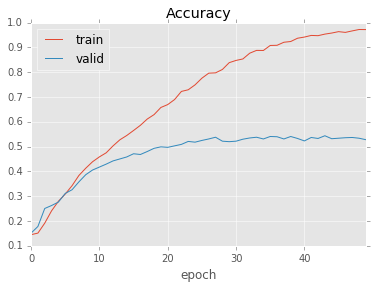

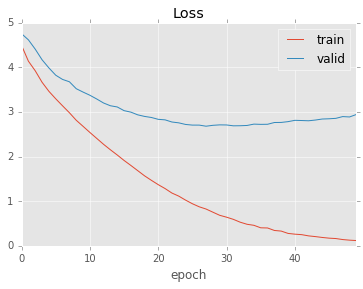

In [365]:
record(hist)

## Residue

In [ ]:
res = model.CNN(maxlen=450, torel=relation, residue=True, filter=100)

In [ ]:
# opt = optim.RMSprop(lr=1.2e-3)
res.compile(loss='categorical_crossentropy',
            optimizer='RMSprop',
            metrics=['acc'])
res.reset()
hist_res = res.fit(trainset, validset, epochs=50, batch_size=128)

Max Valid Acc Epoch
            acc      loss       acc      loss
          train     train     valid     valid
epoch                                        
44     0.936671  0.295464  0.572565  2.552134


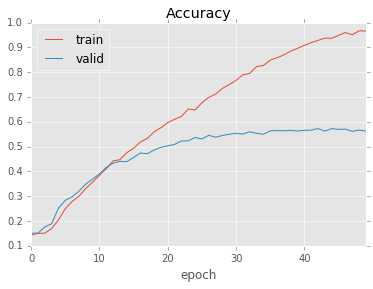

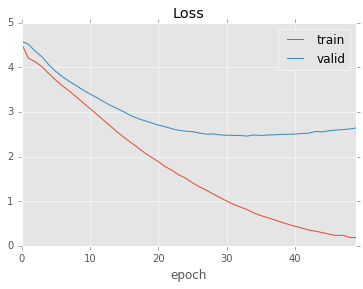

In [307]:
record(hist_res)

## Add CNN layers

In [ ]:
resl4 = model.CNN(maxlen=450, torel=relation, residue=True, filter=25, n_layers=4)

In [ ]:
# opt = optim.RMSprop(lr=1.2e-3)
resl4.compile(loss='categorical_crossentropy',
              optimizer='RMSprop',
              metrics=['acc'])
resl4.reset()
hist_resl4 = resl4.fit(trainset, validset, epochs=50, batch_size=128)

Max Valid Acc Epoch
            acc      loss       acc      loss
          train     train     valid     valid
epoch                                        
40     0.758621  0.931391  0.486083  3.457762


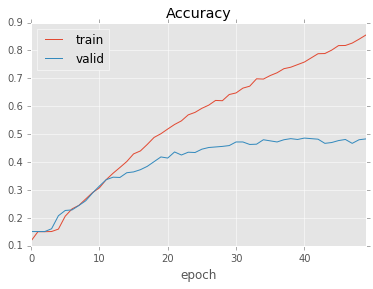

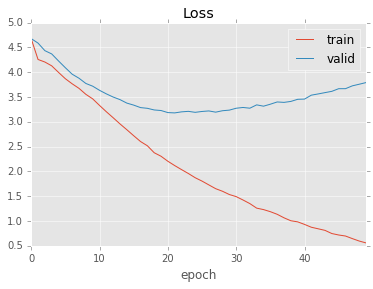

In [308]:
record(hist_resl4)

## Add Dense layers

In [310]:
resden = model.CNN(maxlen=450, torel=relation, residue=True, dense_layers=100, filter=100)

In [ ]:
# opt = optim.RMSprop(lr=1.2e-3)
resden.compile(loss='categorical_crossentropy',
               optimizer='RMSprop',
               metrics=['acc'])
resden.reset()
hist_resden = resden.fit(trainset, validset, epochs=50, batch_size=128)

Max Valid Acc Epoch
            acc     loss       acc      loss
          train    train     valid     valid
epoch                                       
39     0.869032  0.53962  0.571571  2.690347


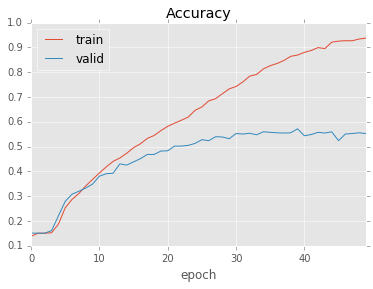

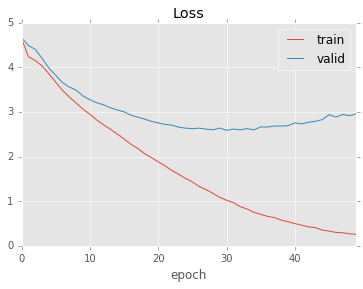

In [312]:
record(hist_resden)

## I want to be Henry

In [314]:
fakehenry = model.CNN(maxlen=450, torel=relation, residue=True, dense_layers=[150, 75], filter=300)

In [ ]:
# opt = optim.RMSprop(lr=1.2e-3)
fakehenry.compile(loss='categorical_crossentropy',
                  optimizer='RMSprop',
                  metrics=['acc'])
fakehenry.reset()
hist_fakehenry = fakehenry.fit(trainset, validset, epochs=50, batch_size=128)

Max Valid Acc Epoch
           acc      loss       acc      loss
         train     train     valid     valid
epoch                                       
47     0.91744  0.265051  0.529821  3.686651


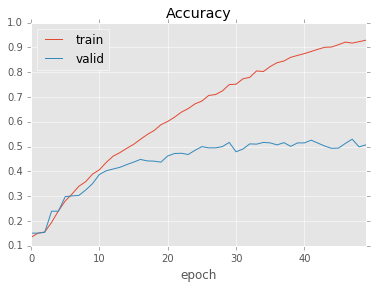

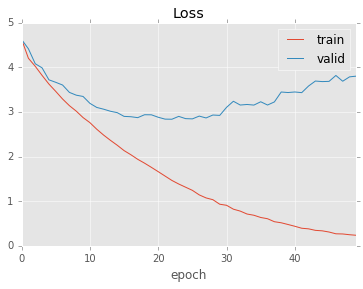

In [316]:
record(hist_fakehenry)

## LSA

In [450]:
reslsa = model.CNN(maxlen=450, torel=relation, residue=True, drop_res=0.5, filter=250, feature=n_svd)
reslsa.featurize = lambda dataset: np.stack(dataset.feature.lsa)

In [ ]:
# opt = optim.RMSprop(lr=1.2e-3)
reslsa.compile(loss='categorical_crossentropy',
               optimizer='RMSprop',
               metrics=['acc'])
reslsa.reset()
hist_reslsa = reslsa.fit(trainset, validset, epochs=50, batch_size=128)

Max Valid Acc Epoch
            acc      loss       acc      loss
          train     train     valid     valid
epoch                                        
49     0.988395  0.049693  0.629225  2.376829


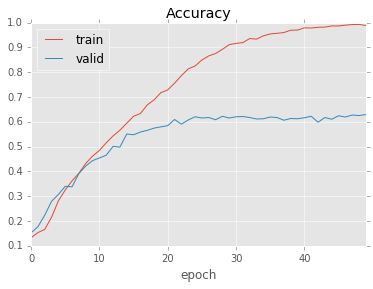

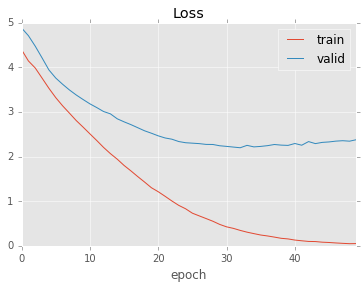

In [471]:
record(hist_reslsa)

## Self Attention: BOOM!

In [472]:
sareslsa = model.CNN(maxlen=450, torel=relation, sa_scale=50, residue=True, drop_res=0.5, filter=250, feature=n_svd)
sareslsa.featurize = lambda dataset: np.stack(dataset.feature.lsa)

In [ ]:
# opt = optim.RMSprop(lr=1.2e-3)
sareslsa.compile(loss='categorical_crossentropy',
                 optimizer='RMSprop',
                 metrics=['acc'])
sareslsa.reset()
hist_sareslsa = sareslsa.fit(trainset, validset, epochs=50, batch_size=128)

Max Valid Acc Epoch
            acc      loss       acc     loss
          train     train     valid    valid
epoch                                       
19     0.615053  1.782423  0.375746  3.88552


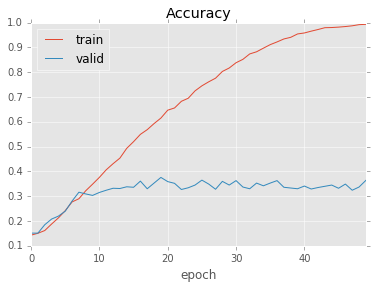

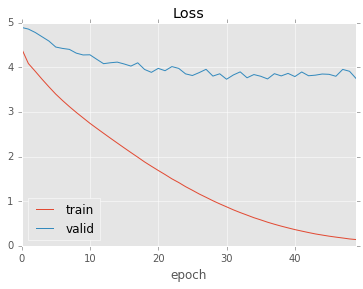

In [474]:
record(hist_sareslsa)

## Henry

In [479]:
henry = model.CNN(maxlen=450, torel=relation, 
                  dense_layers=200, drop_dense=0.5, residue=True, drop_res=0.5, filter=250, feature=n_svd)
henry.featurize = lambda dataset: np.stack(dataset.feature.lsa)

In [ ]:
# opt = optim.RMSprop(lr=1.2e-3)
henry.compile(loss='categorical_crossentropy',
              optimizer='RMSprop',
              metrics=['acc'])
henry.reset()
hist_henry = henry.fit(trainset, validset, epochs=50, batch_size=128)

Max Valid Acc Epoch
            acc      loss       acc      loss
          train     train     valid     valid
epoch                                        
48     0.785809  0.856212  0.636183  2.288241


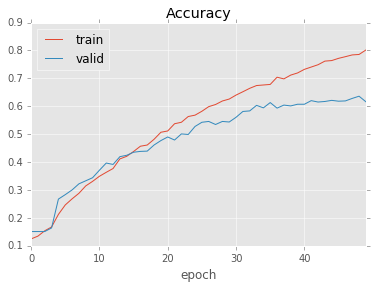

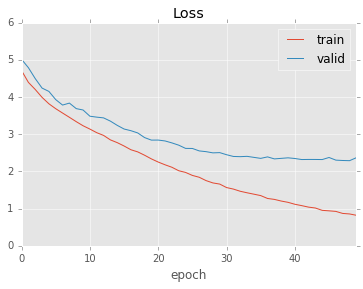

In [481]:
record(hist_henry)

## Henry-2

In [482]:
henry2 = model.CNN(maxlen=450, torel=relation, 
                  dense_layers=[200, 100], drop_dense=0.3, residue=True, drop_res=0.5, filter=100, feature=n_svd)
henry2.featurize = lambda dataset: np.stack(dataset.feature.lsa)

In [ ]:
# opt = optim.RMSprop(lr=1.2e-3)
henry2.compile(loss='categorical_crossentropy',
               optimizer='RMSprop',
               metrics=['acc'])
henry2.reset()
hist_henry2 = henry2.fit(trainset, validset, epochs=80, batch_size=128)

Max Valid Acc Epoch
            acc      loss       acc      loss
          train     train     valid     valid
epoch                                        
59     0.800066  0.778056  0.656064  2.178043


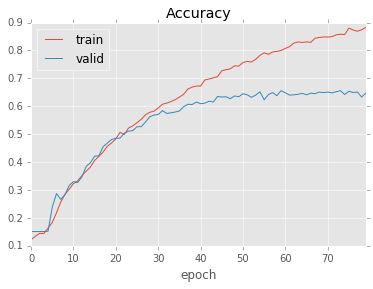

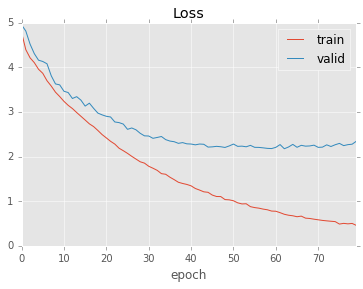

In [486]:
record(hist_henry2)